In [1]:
%matplotlib inline
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

In [18]:
# load total energy data
data = pd.read_csv('nrelmatdb_energies.csv')

In [19]:
data

,composition,icsdnum,energyperatom,E-Emin
0,Hf1N1,183420.0,-9.855,0.000
1,Hf1N1,183419.0,-9.855,0.000
2,Hf3N4,97997.0,-9.822,0.000
3,Hf1N1,167875.0,-9.663,0.192
4,Hf1O2,71354.0,-9.608,0.017
...,...,...,...,...
16440,F1O1Sb1,19019.0,-5.490,0.002
16441,Br3F3N3P3,16099.0,-5.330,0.000
16442,C1Ca2F2O3,100607.0,-6.812,0.000
16443,F2Mg5O8Si2,252072.0,-6.631,0.000


In [20]:
# we only need "composition" and "energyperatom"
data = data.drop(['icsdnum','E-Emin'],axis=1)

In [21]:
# create composition objects to be used for computing features
data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'composition')

In [22]:
# build features from compositions
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

In [23]:
# assign names to features
feature_labels = feature_calculators.feature_labels()

In [24]:
# compute features using composition objects
data = feature_calculators.featurize_dataframe(data, col_id='composition_obj');

In [25]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

Generated 145 features
Training set size: 16445x145


In [26]:
data.head(2)

,composition,energyperatom,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,Hf1N1,-9.855,"(Hf, N)",2,0.707107,0.629961,0.574349,0.552045,0.535887,7.0,...,194.0,0.0,194.0,2.0,1.5,1.0,7.0,False,0.530882,0.13272
1,Hf1N1,-9.855,"(Hf, N)",2,0.707107,0.629961,0.574349,0.552045,0.535887,7.0,...,194.0,0.0,194.0,2.0,1.5,1.0,7.0,False,0.530882,0.13272


In [27]:
data = data.drop(['composition','composition_obj'],axis=1)

In [28]:
# separate data into "labels" and "features". labels are quantities to be predicted (energyperatom in this case)
labels = np.array(data['energyperatom'])

# Remove the labels from the features
# axis 1 refers to the columns
data= data.drop('energyperatom', axis = 1)

# Saving feature names for later use
feature_list = list(data.columns)

# Convert to numpy array
features = np.array(data)

In [29]:
# split data into training and testing sets using train_test_split function from Scikit-learn
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [30]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (12333, 145)
Training Labels Shape: (12333,)
Testing Features Shape: (4112, 145)
Testing Labels Shape: (4112,)


In [31]:
# initialize the model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# train the model on training data
rf.fit(train_features, train_labels);

In [32]:
# make predictions on test set
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'eV/atom')

Mean Absolute Error: 0.12 eV/atom


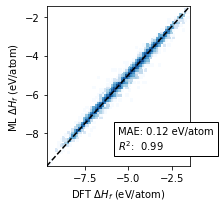

In [33]:
# plot the predictions against true DFT values
fig, ax = plt.subplots()

ax.hist2d(test_labels, predictions, norm=LogNorm(), bins=64, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(test_labels, predictions)
r2 = metrics.r2_score(test_labels, predictions)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()

In [34]:
# evaluate feature importances

# get numerical feature importances
importances = list(rf.feature_importances_)

# list of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MagpieData mode CovalentRadius Importance: 0.21
Variable: MagpieData mean NdUnfilled Importance: 0.18
Variable: MagpieData minimum CovalentRadius Importance: 0.17
Variable: MagpieData mean NUnfilled Importance: 0.16
Variable: MagpieData avg_dev NdValence Importance: 0.04
Variable: MagpieData mode NUnfilled Importance: 0.03
Variable: MagpieData range NUnfilled Importance: 0.02
Variable: MagpieData mean MeltingT Importance: 0.01
Variable: MagpieData avg_dev MeltingT Importance: 0.01
Variable: MagpieData mode MeltingT Importance: 0.01
Variable: MagpieData maximum NdValence Importance: 0.01
Variable: MagpieData mean NdValence Importance: 0.01
Variable: MagpieData mode NValence Importance: 0.01
Variable: MagpieData mean NpUnfilled Importance: 0.01
Variable: MagpieData mode NpUnfilled Importance: 0.01
Variable: MagpieData minimum NUnfilled Importance: 0.01
Variable: avg d valence electrons Importance: 0.01
Variable: 0-norm               Importance: 0.0
Variable: 2-norm             